# **Rodrigo_Mesquita_PB_TP3**
## **Projeto de Bloco: Inteligência Artificial e Machine Learning [24E1_5]**

## 1.Criação das features:Aplicar Análise de Componentes Principais (PCA) para reduzir a dimensionalidade dos conjuntos de dados.

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split


In [76]:
df = pd.read_csv('/workspaces/Faculdade/Datasets/healthcare-dataset-stroke-data.csv')

In [77]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [78]:
df.drop(columns=['id'], inplace=True)

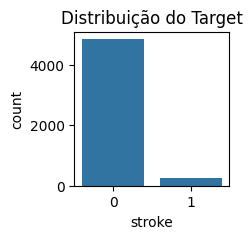

In [79]:
#Checando a distribuição
plt.figure(figsize=(2,2))
plt.title('Distribuição do Target')
sns.countplot(df, x='stroke')
plt.show()

In [80]:
# O dataset é altamente desbalanceado e apenas 5% das linhas são de paciêntes que tiveram derrame
print('Total de linhas:', df.shape[0])
print('Qtd linhas com Stroke=1:' ,len(df[df['stroke'] == 1]))

Total de linhas: 5110
Qtd linhas com Stroke=1: 249


In [81]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [82]:
#Checando se há dados nulos
nulls = df.isnull().sum()
print(nulls)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [83]:
#Terei de tratar as amostras com BMI nulo, pois representam 16% das pessoas que tiveram derrame.
print('Qtd linhas com Stroke=1:', len(df[df['stroke'] == 1]))
print('Qtd linhas com Stroke=1 e BMI nulo:', len(df[(df['stroke'] == 1) & (df['bmi'].isnull())]))

Qtd linhas com Stroke=1: 249
Qtd linhas com Stroke=1 e BMI nulo: 40


In [84]:
df[df['stroke'] == 1].groupby(['gender', 'age','stroke']).mean(['bmi'])

hypertension  heart_disease  avg_glucose_level     bmi
gender age   stroke                                                        
Female 1.32  1           0.000000       0.000000          70.370000     NaN
       14.00 1           0.000000       0.000000          57.930000  30.900
       32.00 1           0.000000       0.000000          76.130000  29.900
       38.00 1           0.000000       0.000000          91.865000  24.000
       39.00 1           0.333333       0.000000          79.696667  31.700
...                           ...            ...                ...     ...
Male   78.00 1           0.416667       0.083333         130.494167  26.425
       79.00 1           0.250000       0.250000          98.125000  25.500
       80.00 1           0.285714       0.571429         172.328571  28.700
       81.00 1           0.166667       0.166667         152.333333  29.100
       82.00 1           0.000000       0.600000         148.818000  28.480

[74 rows x 4 columns]

In [85]:
#Criando faixas de idade
df_norm = df.copy()
df_norm['faixa_age'] = round(df_norm['age']/10)

#Criando uma coluna com o bmi médio para amostras da mesma faixa de idade, gênero e stroke
df_norm['bmi_mean'] = df_norm.groupby(['gender', 'faixa_age','stroke'])['bmi'].transform('mean')
df_norm['bmi'] = df_norm['bmi'].fillna(df_norm['bmi_mean'])

#deletando as colunas temporárias
df_norm = df_norm.drop(columns=['bmi_mean','faixa_age'], axis=1)

In [86]:
#Após transformação sobrou apenas um registro com BMI nulo, então o deletei.
print('Qtd linhas que sobraram com Stroke=1 e BMI nulo:', len(df_norm[(df_norm['stroke'] == 1) & (df_norm['bmi'].isnull())]))
df_norm.dropna(inplace=True)

print('Após realizar drop_na:', len(df_norm[(df_norm['stroke'] == 1) & (df_norm['bmi'].isnull())]))

Qtd linhas que sobraram com Stroke=1 e BMI nulo: 1
Após realizar drop_na: 0


In [ ]:
df_norm

In [ ]:
X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [89]:
X = df_norm.drop(columns=['stroke'])
pca = PCA().fit(X)  # X é a sua matriz de features

# Método do Cotovelo
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.show()

# Critério da Variância Acumulada
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumsum_variance >= 0.95) + 1  # Escolha 95% ou outro valor desejado
print(f'Número ideal de componentes para explicar 95% da variância: {n_components}')

ValueError: could not convert string to float: 'Male'

## 2.Modelo de ML:  Desenvolver e treinar modelos de árvores de decisão para tarefas de classificação.

## 3.Avaliação de Modelos: Aplicar técnicas de validação cruzada para estimar a eficiência dos modelos desenvolvidos.

## 4.Busca Hiperparamétrica: Utilizar GridSearch para otimizar os hiperparâmetros dos modelos.

## 5.Pruning de Árvores de Decisão: Realizar o pruning (poda) em árvores de decisão para prevenir o overfitting e melhorar a generalização do modelo.

## 6.Avaliação de Classificadores Binários: Utilizar figuras de mérito como Curva ROC, precisão, recall, f1-score, sensibilidade e especificidade para avaliar os modelos.

## 7.Baseado nos valores encontrados para as diferentes figuras de mérito, interprete os resultados e disserte sobre a eficiência do classificador criado.